# Implementação de uma classe para simular um array de microfones 

A ideia desse jupyter é implementar uma classe que receba o caminho para um arquivo de áudio WAV e realize todo o processamento para simular um array de microfones com ou sem ruído.

O construtor da classe deverá realizar todo o processamento, setando os arrays de sinais e de delays, que serão públicos. Deverá haver um método que retorna essas dois arrays.

In [8]:
import librosa
import numpy as np
import math
import matplotlib.pyplot as plt
from random import randint
from IPython.display import Audio

## Definindo as coordenadas dos microfones

Com o ReSpeaker 4 mic array, é conveniente adotar **coordenadasOriginaisMics** como as coordenadas dos microfones. Mas, como não há nada no eixo Z, é necessário utilizar uma matriz de rotação para ter informação em todas as dimensões (caso contrário, o produto interno não vai funcionar).

https://en.wikipedia.org/wiki/Rotation_matrix#In_three_dimensions

In [31]:
def grausParaRad(angRad):
    return (angRad * math.pi)/180

In [19]:
coordenadasOriginaisMics = np.array([
    [0.0000, 0.0000, 0.0000],
    [0.0000, 0.0585, 0.0000],
    [0.0585, 0.0585, 0.0000],
    [0.0585, 0.0000, 0.0000]
])

anguloRad = grausParaRad(45)

matrizRotacaoEixoX = np.array([
    [1, 0, 0],
    [0, math.cos(anguloRad), math.sin(anguloRad)],
    [0, math.sin(anguloRad), -math.cos(anguloRad)]
])

coordenadasRotacionadasMics = np.matmul(coordenadasOriginaisMics, matrizRotacaoEixoX)

print(coordenadasRotacionadasMics)

[[0.         0.         0.        ]
 [0.         0.04136575 0.04136575]
 [0.0585     0.04136575 0.04136575]
 [0.0585     0.         0.        ]]


## Abrindo um áudio para para testar as funções

A simulação 3 contém apenas um arquivo mono de um sinal de volz puro. Vou criar funções para simular um array de microfones.

In [20]:
caminhoSinal = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono.wav'

sinalPuroMono, freqAmostragem = librosa.load(caminhoSinal, sr=None, mono=True)

In [21]:
Audio(data=sinalPuroMono, rate=freqAmostragem)

## Definição de funções

#### Função para transformar de graus para radianos

In [32]:
def grausParaRad(angRad):
    return (angRad * math.pi)/180

In [34]:
print(grausParaRad(180))

3.141592653589793


#### Função para fazer o produto interno

In [33]:
def calcularProdutoInterno(vetorA, vetorB):
    
    soma = 0
    
    for i in range(len(vetorA)):
        soma += vetorA[i] * vetorB[i]
        
    return soma

In [35]:
vetorA = [1, 2, 3]
vetorB = [3, 2, 1]
print(calcularProdutoInterno(vetorA, vetorB))

10


#### Função para transformar segundos em amostras

In [36]:
def segundosParaAmostras(segundos, freqAmostragem):
    return freqAmostragem * segundos

#### Função para gerar ruído branco

Depois, para facilitar o cálculo da SNR, preciso que essa função também faça o ruído ter uma energia (variância) específica.

In [22]:
def gerarRuidoBranco(qtdAmostras, energia):
    
    media        = 0
    desvioPadrao = 1
    
    return np.random.normal(media, desvioPadrao, size=qtdAmostras) * energia**(1/2)

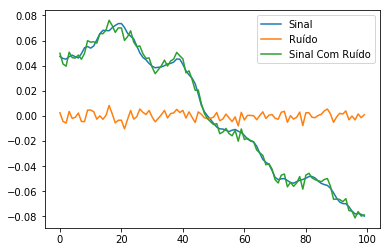

In [23]:
ruido = gerarRuidoBranco(len(sinalPuroMono), 0.00001)
sinalComRuido = sinalPuroMono + ruido

inicio = 10000
fim    = 10100

plt.plot(sinalPuroMono[inicio:fim], label="Sinal")
plt.plot(ruido[inicio:fim], label="Ruído")
plt.plot(sinalComRuido[inicio:fim], label="Sinal Com Ruído")
plt.legend()
plt.show()

In [24]:
Audio(data=sinalComRuido, rate=freqAmostragem)

#### Função para gerar um array de delays entre os microfones

Essa função precisará receber as coordenadas dos microfones para gerar os delays entre eles de acordo com os angulos azimutal e de elevação, que serão aleatórios.

Para achar os delays entre os microfones basta fazer o algoritmo do produto interno.

In [73]:
def obterArrayDelays(coordenadasMics, freqAmostragem, velocidadeSom=340.29, azimutalRad=None, elevacaoRad=None):
    
    arrayDelays = []
    
    # GERANDO AZIMUTAL E ELEVACAO ALEATORIOS (EM RAD)
    if azimutalRad == None:
        azimutalRad = grausParaRad(randint(0, 359))
    if elevacaoRad == None:
        elevacaoRad = grausParaRad(randint(-90, 90))
    
    # CONVERTENDO PARA UM VETOR UNITARIO
    vetorWavefront = [
        math.cos(elevacaoRad) * math.cos(azimutalRad),
        math.cos(elevacaoRad) * math.sin(azimutalRad),
        math.sin(elevacaoRad)
    ]
    
    # PARA CADA MICROFONE
    for coordenadasOriginaisMicAtual in coordenadasMics:
        
        # EU FACO A DIFERENCA DAS COORDENADAS ATUAIS PRAS COORDENADAS DO MICROFONE DA ORIGEM
        coordenadasModificadasMicAtual = np.array(coordenadasOriginaisMicAtual) - np.array(coordenadasMics[0])
        
        # CALCULO DELAY USANDO O PRODUTO INTERNO DAS COORDENADAS DO MIC ATUAL COM O VETOR WAVEFRONT
        delayAtual = calcularProdutoInterno(vetorWavefront, coordenadasModificadasMicAtual)/velocidadeSom
        delayAtual = segundosParaAmostras(delayAtual, freqAmostragem)
        delayAtual = int(round(delayAtual))
        arrayDelays.append(delayAtual)
        
    return arrayDelays

In [78]:
coordenadasMics = [
    [0.0, 0.0, 0.0],
    [0.5, 0.2, 0.1]
]

azimutal = grausParaRad(30)
elevacao = grausParaRad(10)

arrayDelays = obterArrayDelays(coordenadasMics, freqAmostragem, azimutalRad=azimutal, elevacaoRad=elevacao)
print(arrayDelays)
print(arrayDelays[1]/freqAmostragem)

[0, 70]
0.0015873015873015873


In [193]:
coordenadasMics = [
    [0     , 0         , 0         ],
    [0     , 0.04136575, 0.04136575],
    [0.0585, 0.04136575, 0.04136575],
    [0.0585, 0         , 0         ]
]

arrayDelays = obterArrayDelays(coordenadasMics, freqAmostragem)
print(arrayDelays)

[0, 5, -1, -5]


#### Função para gerar um array de microfones e o delay entre eles

A função abaixo vai receber um sinal mono e o array de delays para gerar um array de sinais. Basta copiar e colar o sinal mono e defasar de acordo com o array de delays. Essa função vai devolver o array de sinais.

In [147]:
def simularArrayMicrofones(sinalPuroMono, arrayDelays):
    
    # ARRAY DE SINAIS
    arraySinaisSimulados = []
    
    # PARA CADA DELAY ENTRE OS MICROFONES
    for delayAtual in arrayDelays:
        
        # SE FOR POSITIVO, EU COMO UMA PARTE DO SINAL NO COMECO E PREENCHO COM ZEROS NO FINAL
        if delayAtual >= 0:
            sinalMicAtual = np.concatenate((sinalPuroMono[delayAtual:], np.zeros(delayAtual)))
            
        # SE FOR NEGATIVO, EU COLOCO ZEROS NO COMECO E CORTO DO FINAL
        else:
            sinalMicAtual = np.concatenate((np.zeros(-delayAtual), sinalPuroMono[:delayAtual]))
            
        # COLOCO O SINAL COPIADO E DEFASADO NO ARRAY DE MICROFONES
        arraySinaisSimulados.append(sinalMicAtual)
    
    return arraySinaisSimulados

[0, 5, -1, -5]


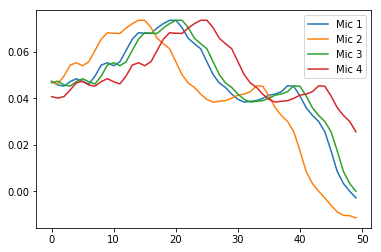

In [199]:
arraySinaisSimulados = simularArrayMicrofones(sinalPuroMono, arrayDelays)

print(arrayDelays)

inicio = 10000
fim    = 10050

for i, sinalAtual in enumerate(arraySinaisSimulados):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
    
plt.legend()
plt.show()

#### Função para adicionar ruido a cada um dos microfones

O ruído não poderá ser defasado, pois ele vem de todas as direções. Essa função vai utilizar a função que gera o ruído.

In [153]:
def adicionarRuido(arraySinaisSimulados, energiaRuido):
    
    ruido = gerarRuidoBranco(len(arraySinaisSimulados[0]), energiaRuido)
    
    for i, sinalAtual in enumerate(arraySinaisSimulados):
        arraySinaisSimulados[i] = sinalAtual + ruido
    
    return arraySinaisSimulados

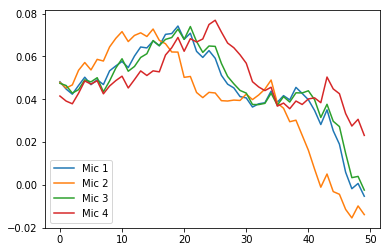

In [202]:
arraySinaisSimulados = adicionarRuido(arraySinaisSimulados, 0.000005)
sinalSemBeamforming  = np.sum(arraySinaisSimulados, axis=0)/len(arraySinaisSimulados)

for i, sinalAtual in enumerate(arraySinaisSimulados):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
    
plt.legend()
plt.show()

In [203]:
print("Sinal de um único microfone com ruído")
Audio(data=arraySinaisSimulados[0], rate=freqAmostragem)

Sinal de um único microfone com ruído


In [156]:
print("Sinal dos microfones somados (sem beamforming)")
Audio(data=sinalSemBeamforming, rate=freqAmostragem)

Sinal dos microfones somados (sem beamforming)


#### Função construtora para unir tudo

Abaixo, vou criar a função construtora que apenas recebe o caminho para um arquivo WAV, a quantidade de microfones desejada e se deve adicionar ruido branco nos microfones. 

Aqui, como retorno, ela vai enviar o array de sinais simulados, o delay entre eles e a frequência de amostragem do arquivo em questão. Mas, quando for implementar a classe, de fato, não posso fazer o construtor retornar alguma coisa. Por isso, esses dois arrays citados serão globais na classe, e a frequência de amostragem também, e haverá uma função que retorna tudo isso.

In [204]:
def construtor(caminhoArquivo, energiaRuido=None, coordenadasMics=[[0,0,0],[0,0.04137,0.04137],[0.0585,0.04137,0.04137],[0.0585,0,0]]):
    
    # ABRINDO O ARQUIVO MONO PURO
    sinalPuroMono, freqAmostragem = librosa.load(caminhoArquivo, sr=None, mono=True)
    
    # GERANDO UM DELAY ENTRE OS MICROFONES
    arrayDelays = obterArrayDelays(coordenadasMics, freqAmostragem)
    
    # GERANDO OS SINAIS DE CADA MICROFONE DE ACORDO COM OS DELAYS GERADOS
    arraySinaisSimulados = simularArrayMicrofones(sinalPuroMono, arrayDelays)
    
    # ADICIONANDO RUIDO
    if energiaRuido != None:
        arraySinaisSimulados = adicionarRuido(arraySinaisSimulados, energiaRuido)
    
    return arraySinaisSimulados, arrayDelays, freqAmostragem

Array de delays: [0, 3, -3, -5]


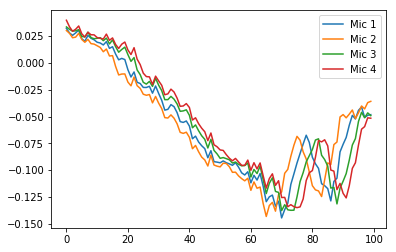

In [245]:
caminhoArquivo = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono2Segundos.wav'
arraySinaisSimulados, arrayDelays, freqAmostragem = construtor(caminhoArquivo, energiaRuido=0.00001)

print("Array de delays:", arrayDelays)

inicio = 10000
fim    = 10100
for i, sinalAtual in enumerate(arraySinaisSimulados):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
plt.legend()
plt.show()

In [246]:
Audio(data=arraySinaisSimulados[0], rate=freqAmostragem)

# Finalmente criando a classe

In [5]:
# Implementação de uma classe para simular um array de microfones
# A ideia desse jupyter é implementar uma classe que receba o caminho para um arquivo de áudio WAV e realize todo o processamento para simular um array de microfones com ou sem ruído.
# O construtor da classe deverá realizar todo o processamento, setando os arrays de sinais e de delays, que serão públicos. Deverá haver um método que retorna essas dois arrays.

# PARA USAR A CLASE:

# EXEMPLO----------------------------------------------

# IMPORTANDO A CLASSE DE SIMULACAO DE ARRAY DE MICROFONES
# from SimularArrayMicrofonesClass import SimularArrayMicrofones

# # DEFININDO OS PARAMETROS INICIAIS
# caminhoArquivo   = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono2Segundos.wav'
# cooredenadasMics = Null para coordenadas padrão ou uma matriz onde as linhas são os microfones
# energiaRuido     = 0.01

# # INSTANCIANDO UM OBJETO DA CLASSE 
# objSimularArrayMics = SimularArrayMicrofones(caminhoArquivo, energiaRuido, coordenadas)

# # OBTENDO O ARRAY DE SINAIS E DE DELAYS E A FREQ DE AMOSTRAGEM
# arraySinaisSimulados, arrayDelays, freqAmostragem = objSimularArrayMics.obterResultado()
#-----------------------------------------------------------

import librosa
import numpy as np
import math
from random import randint

class SimularArrayMicrofones:

	arraySinaisSimulados = []
	arrayDelays          = []
	freqAmostragem       = 0

	def __init__(self, caminhoArquivo, energiaRuido=None, coordenadasMics=[[0,0,0],[0,0.04137,0.04137],[0.0585,0.04137,0.04137],[0.0585,0,0]]):    
		# ABRINDO O ARQUIVO MONO PURO
		sinalPuroMono, self.freqAmostragem = librosa.load(caminhoArquivo, sr=None, mono=True)
		
		# GERANDO UM DELAY ENTRE OS MICROFONES
		self.arrayDelays = self.obterArrayDelays(coordenadasMics, self.freqAmostragem)
		
		# GERANDO OS SINAIS DE CADA MICROFONE DE ACORDO COM OS DELAYS GERADOS
		self.arraySinaisSimulados = self.simularArrayMicrofones(sinalPuroMono, self.arrayDelays)
		
		# ADICIONANDO RUIDO
		if energiaRuido != None:
			self.arraySinaisSimulados = self.adicionarRuido(self.arraySinaisSimulados, energiaRuido)

	def obterResultado(self):
		return self.arraySinaisSimulados, self.arrayDelays, self.freqAmostragem

	def gerarRuidoBranco(self, qtdAmostras, energiaRuido):

		media        = 0
		desvioPadrao = 1
		
		return np.random.normal(media, desvioPadrao, size=qtdAmostras) * energiaRuido**(1/2)

	def calcularProdutoInterno(self, vetorA, vetorB):
		soma = 0	    
		for i in range(len(vetorA)):
			soma += vetorA[i] * vetorB[i]      
		return soma

	def grausParaRad(self, angRad):
		return (angRad * math.pi)/180

	def segundosParaAmostras(self, segundos, freqAmostragem):
		return freqAmostragem * segundos

	def obterArrayDelays(self, coordenadasMics, freqAmostragem, velocidadeSom=340.29, azimutalRad=None, elevacaoRad=None):
		# Função para gerar um array de delays entre os microfones
		# Essa função precisará receber as coordenadas dos microfones para gerar os delays entre eles de acordo com os angulos azimutal e de elevação, que serão aleatórios.
		# Para achar os delays entre os microfones basta fazer o algoritmo do produto interno.
		
		arrayDelays = []
		
		# GERANDO AZIMUTAL E ELEVACAO ALEATORIOS (EM RAD)
		if azimutalRad == None:
			azimutalRad = self.grausParaRad(randint(0, 359))
		if elevacaoRad == None:
			elevacaoRad = self.grausParaRad(randint(-90, 90))
		
		# CONVERTENDO PARA UM VETOR UNITARIO
		vetorWavefront = [
			math.cos(elevacaoRad) * math.cos(azimutalRad),
			math.cos(elevacaoRad) * math.sin(azimutalRad),
			math.sin(elevacaoRad)
		]
		
		# PARA CADA MICROFONE
		for coordenadasOriginaisMicAtual in coordenadasMics:
			
			# EU FACO A DIFERENCA DAS COORDENADAS ATUAIS PRAS COORDENADAS DO MICROFONE DA ORIGEM
			coordenadasModificadasMicAtual = np.array(coordenadasOriginaisMicAtual) - np.array(coordenadasMics[0])
			
			# CALCULO DELAY USANDO O PRODUTO INTERNO DAS COORDENADAS DO MIC ATUAL COM O VETOR WAVEFRONT
			delayAtual = self.calcularProdutoInterno(vetorWavefront, coordenadasModificadasMicAtual)/velocidadeSom
			delayAtual = self.segundosParaAmostras(delayAtual, freqAmostragem)
			delayAtual = int(round(delayAtual))
			arrayDelays.append(delayAtual)
			
		return arrayDelays

	def simularArrayMicrofones(self, sinalPuroMono, arrayDelays):
		# Função para gerar um array de microfones e o delay entre eles
		# A função abaixo vai receber um sinal mono e vai gerar um array de sinais. Basta copiar e colar o sinal mono e defasar aleatoriamente. Essa função vai devolver o array de sinais e o delay entre eles.
		# ARRAY DE SINAIS
		arraySinaisSimulados = []
		
		# PARA CADA DELAY ENTRE OS MICROFONES
		for delayAtual in arrayDelays:
			
			# SE FOR POSITIVO, EU COMO UMA PARTE DO SINAL NO COMECO E PREENCHO COM ZEROS NO FINAL
			if delayAtual >= 0:
				sinalMicAtual = np.concatenate((sinalPuroMono[delayAtual:], np.zeros(delayAtual)))
				
			# SE FOR NEGATIVO, EU COLOCO ZEROS NO COMECO E CORTO DO FINAL
			else:
				sinalMicAtual = np.concatenate((np.zeros(-delayAtual), sinalPuroMono[:delayAtual]))
				
			# COLOCO O SINAL COPIADO E DEFASADO NO ARRAY DE MICROFONES
			arraySinaisSimulados.append(sinalMicAtual)
		
		return arraySinaisSimulados
	
	def adicionarRuido(self, arraySinaisSimulados, energiaRuido):
		# Função para adicionar ruido a cada um dos microfones
		# O ruído não poderá ser defasado, pois ele vem de todas as direções. Essa função vai utilizar a função que gera o ruído.
		ruido = self.gerarRuidoBranco(len(arraySinaisSimulados[0]), energiaRuido)
		
		for i, sinalAtual in enumerate(arraySinaisSimulados):
			arraySinaisSimulados[i] = sinalAtual + ruido
		
		return arraySinaisSimulados
	

Array de delays: [0, 7, 10, 2]


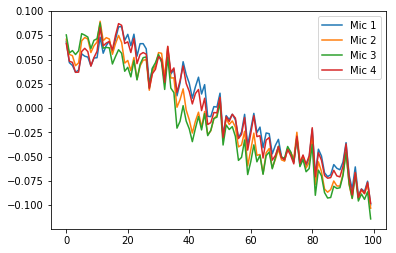

In [17]:
# INSTANCIANDO UM OBJETO DA CLASSE 
caminhoArquivo      = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono.wav'
objSimularArrayMics = SimularArrayMicrofones(caminhoArquivo, 0.0001)

# OBTENDO O ARRAY DE SINAIS E DE DELAYS E A FREQ DE AMOSTRAGEM
arraySinaisSimulados, arrayDelays, freqAmostragem = objSimularArrayMics.obterResultado()

print("Array de delays:", arrayDelays)

inicio = 10000
fim    = 10100
for i, sinalAtual in enumerate(arraySinaisSimulados):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
plt.legend()
plt.show()

In [18]:
Audio(data=arraySinaisSimulados[0], rate=freqAmostragem)